# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url

%matplotlib inline

## Install h5py
The COCO dataset we will be using is stored in HDF5 format. To load HDF5 files, we will need to install the `h5py` Python package. From the command line, run: 
```
conda install h5py
```
or
```
pip install h5py
```

# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

As a first step you should download the data from http://cs231n.stanford.edu/coco_captioning.zip to `../datasets` directory and unzip it. Warning: the COCO data download is ~1GB.

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `coco_utils.py` to convert numpy arrays of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `coco_utils.py`. Run the following cell to do so:

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data('../datasets/coco_captioning', pca_features=True)

# Print out all the keys and values from the data dictionary
for k in sorted(data.keys()):
    v = data[k]
    if type(v) == np.ndarray:
        print(k + ':', type(v), v.shape, v.dtype)
    else:
        print(k + ':', type(v), len(v))

idx_to_word: <class 'list'> 1004
train_captions: <class 'numpy.ndarray'> (400135, 17) int32
train_features: <class 'numpy.ndarray'> (82783, 512) float32
train_image_idxs: <class 'numpy.ndarray'> (400135,) int32
train_urls: <class 'numpy.ndarray'> (82783,) <U63
val_captions: <class 'numpy.ndarray'> (195954, 17) int32
val_features: <class 'numpy.ndarray'> (40504, 512) float32
val_image_idxs: <class 'numpy.ndarray'> (195954,) int32
val_urls: <class 'numpy.ndarray'> (40504,) <U63
word_to_idx: <class 'dict'> 1004


**Task 1 (1.5pts):**

http://farm4.staticflickr.com/3133/3378902101_3c9fa16b84_z.jpg
[  1   4 145  79  89 779  95   5   4 471   8   4   3   2   0   0   0]


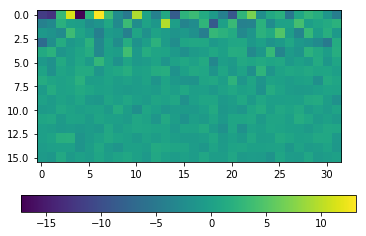

In [41]:
############################################################################
# TODO: Take a closer look on those values by printing out the features,   #
#       image url, encoded caption of first training data sample.          #
#       NB! The same image can be used for several captions!               #
############################################################################
idx_to_word = data['idx_to_word']

sample_idx = data['train_image_idxs'][0]
raw_caption = data['train_captions'][sample_idx]
pca_features = data['train_features'][sample_idx]
im_url = data['train_urls'][sample_idx]

print(im_url)
print(raw_caption)

features = pca_features.reshape((16, -1))
im = plt.imshow(features)
plt.colorbar(im, orientation='horizontal')
plt.show()
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL, so **you must be connected to the internet to view images**.

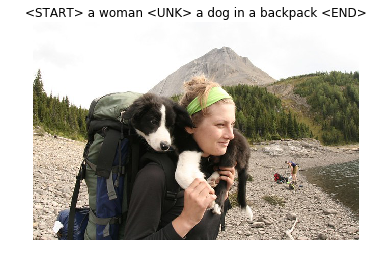

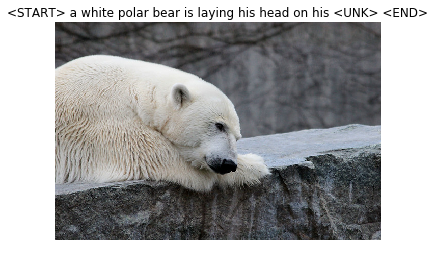

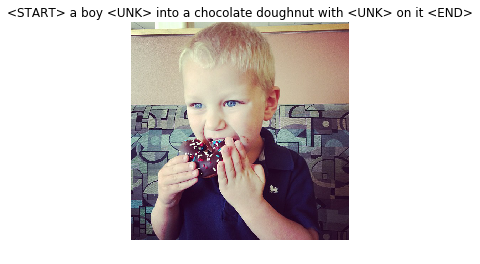

In [44]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# RNN for image captioning

The image captioning model has two input branches - the image and text (because text generation depends on the previous word). Image features are passed through the Dense layer to produce initial hidden state for the RNN. Then the RNN walks over the input text and predicts next word at every step. We are using text as input to provide known correct previous words during training, this is called "teacher forcing". During test time we feed the output from previous step as input to the next step. Output of the network is probability distribution over vocabulary words. During test time we sample from this distribution. Usual categorical cross-entropy loss is used with Adam optimizer.

In [87]:
img_feat_size = data['train_features'].shape[1]
embed_size = 256
lstm_size = 512
maxlen = data['train_captions'].shape[1]
vocab_size = len(data['word_to_idx'])

from keras.layers import Input, Embedding, SimpleRNN, Dense, TimeDistributed
from keras.models import Model
from keras.optimizers import Adam

i = Input(shape=(img_feat_size,))
h = Dense(lstm_size)(i)
#c = Dense(lstm_size)(i)

x = Input(shape=(None,), dtype='int32')
e = Embedding(vocab_size, embed_size, mask_zero=True)(x)

r = SimpleRNN(lstm_size, return_sequences=True)(e, initial_state=h)
p = TimeDistributed(Dense(vocab_size, activation='softmax'))(r)

model = Model(inputs=[i, x], outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=5e-3))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    257024      input_10[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          262656      input_9[0][0]                    
____________________________________________________________________________________________

# Overfit small data
Pay attention how we shift the inputs and outputs!

Run the following to make sure your model overfit a small sample of 100 training examples. You should see losses of less than 0.1.

In [100]:
small_data = load_coco_data(max_train=50)

x_train_images = small_data['train_features'][small_data['train_image_idxs'], :]
x_train_texts = small_data['train_captions'][:, :-1]
y_train_texts = small_data['train_captions'][:, 1:, np.newaxis]
print('Train images:', x_train_images.shape, x_train_images.dtype)
print('Train input texts:', x_train_texts.shape, x_train_texts.dtype)
print('Train output texts:', y_train_texts.shape, y_train_texts.dtype)

history = model.fit([x_train_images, x_train_texts], y_train_texts, batch_size=25, epochs=50)

Train images: (50, 512) float32
Train input texts: (50, 16) int32
Train output texts: (50, 16, 1) int32
Epoch 1/50
50/50 [==============================] - 0s 5ms/step - loss: 6.2573
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 3.7920
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 2.2419
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 1.1002
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.5019
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2325
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1368
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0843
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 11/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 12/50
50/50 [======

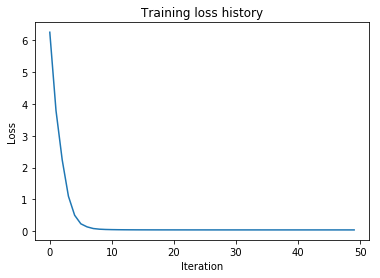

In [101]:
# Plot the training losses
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Test-time sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep. Implement the sampling procedure below.

**Task 2 (5pts):**

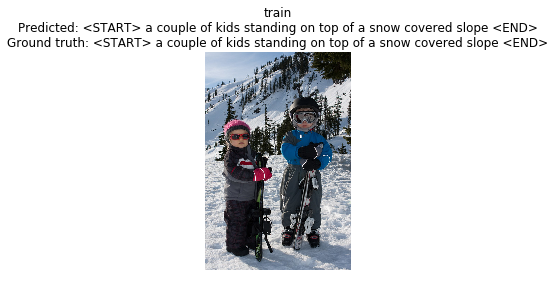

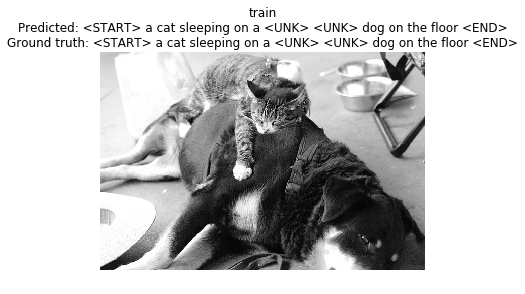

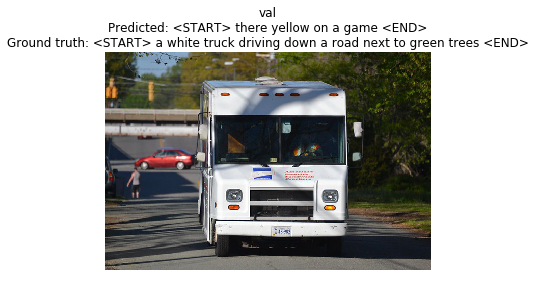

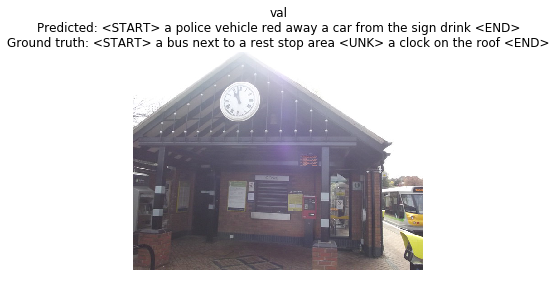

In [102]:
def create_captions(features):
    texts = np.ones((features.shape[0], maxlen), dtype=np.uint)
    ############################################################################
    # TODO: Implement the sampling procedure.                                  #
    #       1) Start with sentence of consisting just ones, the sentence start #
    #          markers.                                                        #
    #       2) Predict the probabilities of next word using just sentence start#
    #          marker as input.                                                #
    #       3) Sample from those probabilities using np.random.choice().       #
    #          NB! You have to make a loop for each sample in batch.           #
    #       4) Store the sampled word index in the next position of sentence.  #
    #       5) Predict the third word with two first words as an input.        #
    #       6) And so on, up to maxlen...                                      #
    ############################################################################
    for word_idx in range(1, maxlen):
        # Use features and first `word_idx` words as input
        # in order to predict `word_idx`-th word
        pred = model.predict([features, texts[:,:word_idx]])

        # Predict next word sample by sample
        for sample_idx in range(features.shape[0]):
            # Define the vocabulary values to choose from
            vocab = list(range(pred.shape[2]))
            
            # Obtain prediction probability distribution over vocabulary
            # for specific sample and word position
            vocab_prob_dist = pred[sample_idx][word_idx-1]

            # Predict next word for specific sample
            texts[sample_idx, word_idx] = np.random.choice(vocab, p=vocab_prob_dist)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return texts

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = create_captions(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\nPredicted: %s\nGround truth: %s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()